In [1]:
import torch
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
matplotlib.rcParams['figure.dpi'] = 150
f_path = "/System/Library/Fonts/Helvetica.ttc"
font_name = fm.FontProperties(fname=f_path).get_name()
rc('font', family=font_name, size=13)


import matplotlib.pyplot as plt
from sentence_transformers import models, SentenceTransformer
from collections import defaultdict
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

from scipy.stats import binned_statistic

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

## Load data

In [2]:
data_indices = [0,1,2,3,4]
model_types = ['model_bert_ft', 'model_roberta-base_ft', 'model_bert', 'model_roberta-base']#, 'model_sbert_ft', 'model_sbert'
model_labels = ['Finetuned BERT', 'Finetuned S-BERT', 'BERT', 'S-BERT'] #, 'Finetuned SBERT roberta', 'SBERT roberta'

In [3]:
def get_accuracy(y,y_hat):
    is_same = (y==y_hat)
    acc = sum(is_same)/len(is_same)
    return acc

def get_f1_score(y, y_hat):
    return f1_score(y, y_hat, average='macro')

In [4]:
model_type = model_types[1] #Focus on S-BERT        

df_samples = []

for data_idx in range(0,5):
    df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe_nodup/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
    df_samples.append(df_sample)
    

In [7]:
df_samples[0].head()

,debate_key,debate_title,username,debate_date,position,is_belief,belief_statement,votelen,predicted_outcome,true_outcome,d_min,d_max,d_avg,d_rel,majority_pred,random_pred,majority_pred_group
1,.-Audis-are-junkers-except-to-rich-kids-with-l...,". Audis are junkers, except to rich kids with ...",Max.Wallace,2014-09-04,Pro,1.0,I agree with the following: . Audis are junker...,141,True,True,20.327677,36.096668,28.212173,0.775740,True,1,False
2,....-Former-Secretary-of-State-Madeleine-Albri...,"....""Former Secretary of State Madeleine Albri...",Lookingatissues,2017-01-30,Pro,1.0,"I agree with the following: ....""Former Secret...",29,True,True,19.105051,37.939125,28.522087,0.985816,True,0,False
4,.9-repeated-is-equal-to-1./1/,.9 repeated is equal to 1.,cowpie1998,2011-04-07,Pro,1.0,I agree with the following: .9 repeated is equ...,1,True,True,33.669617,37.313919,35.491768,0.108237,True,1,False
5,.99-is-equal-to-one./1/,.99 is equal to one.,SweetCrackerJack,2013-12-24,Pro,1.0,I agree with the following: .99 is equal to one.,6,False,True,28.006861,31.512686,29.759773,0.125177,True,0,False
7,.999-repeating-is-equal-to-1-in-reality/1/,.999 repeating is equal to 1 in reality,batman,2008-01-05,Pro,1.0,I agree with the following: .999 repeating is ...,4,True,True,27.081041,30.997705,29.039373,0.144628,True,0,False


### d_rel distribution

In [38]:
x = np.arange(0,2.01,0.1)
y = []
for e in x:
    df_ = df_samples[0]
    y.append(len(df_[df_['d_rel']<e])/len(df_))

In [42]:
for j,k in zip(x,y):
    print("%.1f, %.3f"%(j,k))

0.0, 0.000
0.1, 0.329
0.2, 0.564
0.3, 0.721
0.4, 0.821
0.5, 0.880
0.6, 0.918
0.7, 0.942
0.8, 0.959
0.9, 0.969
1.0, 0.976
1.1, 0.982
1.2, 0.986
1.3, 0.989
1.4, 0.991
1.5, 0.992
1.6, 0.994
1.7, 0.994
1.8, 0.996
1.9, 0.996
2.0, 0.997


Text(0, 0.5, 'Cumulative proportion')

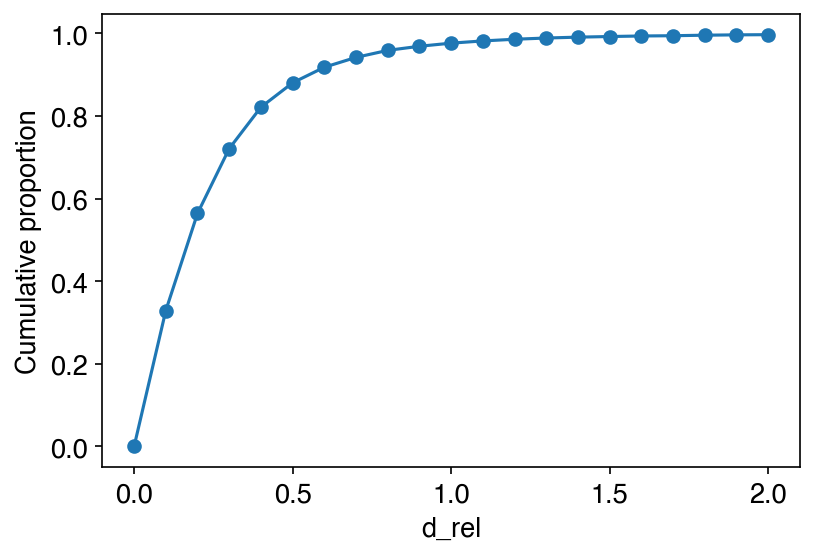

In [35]:
plt.plot(x,y, 'o-')
plt.xlabel('d_rel')
plt.ylabel('Cumulative proportion')

### Debate category information 

In [6]:
import json

with open("../dataset/01_rawdata/debates.json", "r") as f:
    debates = json.load(f)

In [7]:
debatekey2category = {}

for idx, (Adebate, content) in enumerate(debates.items()):
    debatekey2category[Adebate] = content['category']

In [8]:
"""with open('../dataset/debatekey2category_dict.p', 'wb') as f:
    pickle.dump(debatekey2category, f)"""

"with open('../dataset/debatekey2category_dict.p', 'wb') as f:\n    pickle.dump(debatekey2category, f)"

In [9]:
from collections import Counter
cat_count = pd.Series(Counter(debatekey2category.values()))

In [10]:
for df_ in df_samples:
    df_['Category'] = df_['debate_key'].map(debatekey2category)

In [11]:
df_.head()

,debate_key,debate_title,username,debate_date,position,is_belief,belief_statement,votelen,predicted_outcome,true_outcome,d_min,d_max,d_avg,d_rel,majority_pred,random_pred,Category
63730,The-Democratic-Peoples-Republic-of-Korea-is-no...,The Democratic People's Republic of Korea is n...,SteveMaxwell,2015-10-25,Pro,1.0,I agree with the following: The Democratic Peo...,1,True,True,33.886086,34.460941,34.173515,0.016964,True,1,News
63731,The-democrats-are-more-racist-than-the-republi...,The democrats are more racist than the republi...,Flipbook,2014-11-24,Pro,1.0,I agree with the following: The democrats are ...,8,False,True,24.773769,33.301113,29.037441,0.344209,False,0,Politics
63732,The-Democrats-are-not-protecting-the-US-Consti...,The Democrats are not protecting the US Consti...,Flipbook,2013-05-14,Pro,1.0,I agree with the following: The Democrats are ...,8,True,True,28.582182,29.427710,29.004946,0.029582,False,1,Politics
63733,The-Democrats-scare-me./1/,The Democrats scare me.,wingnut2280,2008-01-22,Pro,1.0,I agree with the following: The Democrats scar...,42,True,True,26.525799,27.519587,27.022694,0.037465,False,0,Politics
63734,The-democrats-show-their-true-colors-stalinist...,The democrats show their true colors - stalini...,Solarman1969,2008-02-15,Pro,1.0,I agree with the following: The democrats show...,55,True,True,20.578871,37.711792,29.145332,0.832549,True,1,Politics


## Precition Score over debate category (fig-5d)

In [12]:
#Consider debate categories that appears more than 1000 times. 
top_category = cat_count[cat_count >= 1000]
top_category

Miscellaneous     6277
Politics         15278
Society           7867
Science           4583
Education         5568
Technology        1655
Entertainment     4157
Religion         10287
Economics         1899
Arts              1163
Philosophy        5246
Funny             1394
Health            3182
People            2744
Games             1758
Sports            2267
dtype: int64

In [13]:
category2f1scores = defaultdict(list)
category2avg_drel = defaultdict(list)

In [14]:
for i in range(5):
    for g, df_ in df_samples[i].groupby('Category'):
        if g in top_category:
            category2f1scores[g].append(get_f1_score(df_['true_outcome'], df_['predicted_outcome']))
            category2avg_drel[g].append(df_['d_rel'].mean())

In [15]:
categories = []
f1avgs = []
f1stds = []
avg_drel = []

for c in category2f1scores:
    categories.append(c)
    f1avgs.append(np.mean(category2f1scores[c]))
    f1stds.append(np.std(category2f1scores[c]))
    avg_drel.append(np.mean(category2avg_drel[c]))

In [16]:
category2f1scores

defaultdict(list,
            {'Arts': [0.528708833680129,
              0.5550429820661035,
              0.5116560857396408,
              0.5590944149539494,
              0.5923045435939418],
             'Economics': [0.5387024279753021,
              0.5491326306543698,
              0.5407378982399684,
              0.5739253760681775,
              0.5760984409225616],
             'Education': [0.5362643617302907,
              0.5542356511813882,
              0.555059906860035,
              0.5282904552040453,
              0.5442475774273228],
             'Entertainment': [0.5410999884314491,
              0.5372545221202509,
              0.5464644265831209,
              0.5324951584005634,
              0.5356819839262486],
             'Funny': [0.5247162485065711,
              0.5120519093713435,
              0.516845755383364,
              0.5622236958443855,
              0.49182160651354967],
             'Games': [0.5580538864120953,
              0.4927101067

In [17]:
dat_f1 = pd.DataFrame({'Category':categories, 'Average':f1avgs, 'Std':f1stds, 'd_rel':avg_drel})
dat_f1 = dat_f1.sort_values(by='Average', ascending=False)
dat_f1

,Category,Average,Std,d_rel
11,Religion,0.653643,0.009115,0.330348
9,Philosophy,0.604687,0.015715,0.269065
12,Science,0.602256,0.005790,0.273040
10,Politics,0.567267,0.014378,0.215618
13,Society,0.565476,0.021663,0.210104
6,Health,0.564474,0.018318,0.207528
8,People,0.562121,0.017280,0.234866
1,Economics,0.555719,0.016150,0.214400
0,Arts,0.549361,0.027638,0.213738
2,Education,0.543620,0.010325,0.209512


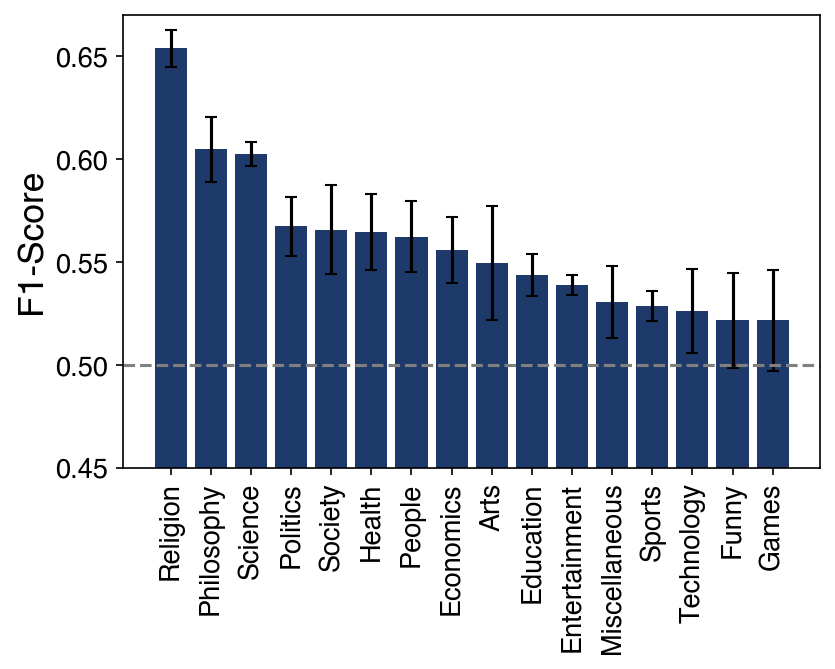

In [18]:
fig, ax = plt.subplots()
plt.bar(np.arange(len(dat_f1)), height=dat_f1['Average'], yerr=dat_f1['Std'], capsize=3,
        color='#1E3A6A', error_kw=dict(ecolor='k'))

plt.ylim(0.45,0.67)
plt.xticks(np.arange(len(dat_f1)), list(dat_f1['Category']), rotation=90)
plt.xlabel('')
plt.ylabel("F1-Score", fontsize=17)
plt.axhline(0.5, ls='--', color='gray')
plt.savefig('../fig/downstream_results/category_vs_f1score.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [19]:
from scipy import stats

corr = stats.pearsonr(dat_f1['d_rel'], dat_f1['Average'])

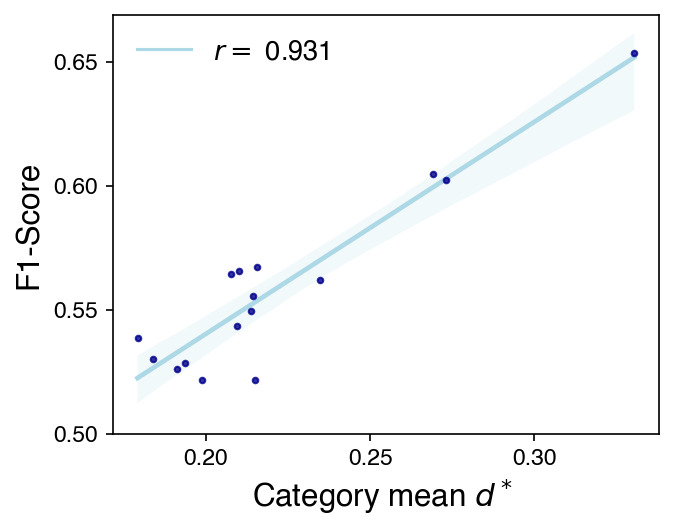

In [20]:
fig, ax = plt.subplots(figsize=(4.7,3.7) )

sns.regplot(data=dat_f1, x='d_rel', y='Average', 
            line_kws={'color':'lightblue'}, ax=ax, scatter=True, 
            scatter_kws={'s':7, 'color':'darkblue', 'alpha':0.8, 'zorder':10})

ax.plot([],[],label = r'$r =$ %.3f'%(corr[0]), color='lightblue')



#for i in range(len(dat_f1)):
#    ax.text(dat_f1['d_rel'].iloc[i],  dat_f1['Average'].iloc[i], dat_f1['Category'].iloc[i], fontsize=4, rotation=70)


plt.xlabel(r'Category mean $d^*$ ', fontsize=15)
plt.ylabel('F1-Score', fontsize=15)
plt.xticks(fontsize=11)
plt.yticks([0.5,0.55,0.6,0.65],fontsize=11)
plt.legend(frameon=False, loc=2, fontsize=13)

plt.savefig('../fig/downstream_results/Downstream_score_vs_debate_category_dstar.pdf',transparent=True, bbox_inches='tight')
#plt.savefig('../fig/downstream_results/Downstream_score_vs_debate_category_dstar_withtext.pdf',transparent=True, bbox_inches='tight')
plt.show()

## Precition Score over distance (fig-5e-h)

### Fig. 5e

In [21]:
df_ = df_samples[0]

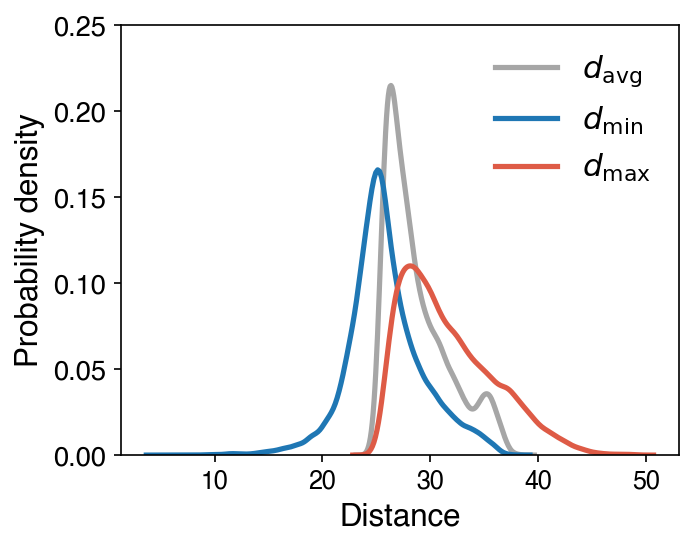

In [22]:
fig, ax = plt.subplots(figsize=(4.8,3.8))
sns.kdeplot(np.array(df_['d_avg']), color='gray', ax=ax, label=r'$d_{\mathrm{avg}}$', lw=2.5, alpha=0.7 )
sns.kdeplot(np.array(df_['d_min']), ax=ax, label=r'$d_{\mathrm{min}}$', lw=2.5, )
sns.kdeplot(np.array(df_['d_max']), color='#DE5B46', ax=ax, label=r'$d_{\mathrm{max}}$', lw=2.5 )
plt.xlabel('Distance', fontsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.ylim(0,0.25)
plt.xticks(fontsize=12)
plt.legend(frameon=False, fontsize=15)
plt.savefig('../fig/downstream_results/distance_distribution.pdf', transparent=True, bbox_inches='tight')
plt.show()

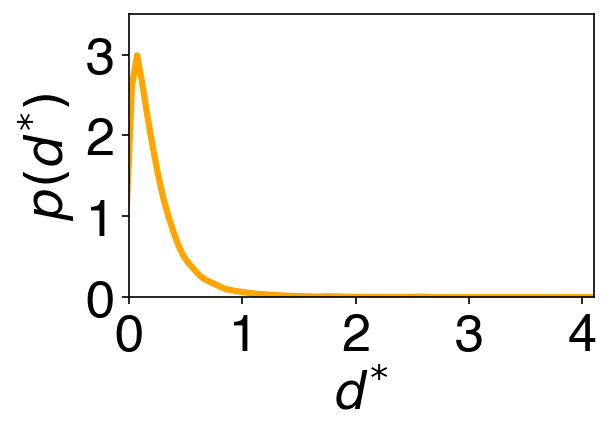

In [23]:
fig, ax = plt.subplots(figsize=(4,2.5))
sns.kdeplot(np.array(df_['d_rel']), color='orange', ax=ax, label=r'$\frac{d_{max}-d_{min}}{d_{min}}$', lw=3 )
plt.xlabel(r'$d^{*}$', fontsize=25)
plt.ylabel(r'$p(d^{*})$', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0,3.5)
plt.xlim(0,4.1)
plt.savefig('../fig/downstream_results/distance_distribution_(d_rel).pdf', transparent=True, bbox_inches='tight')
plt.show()


### Fig. 5f-g

In [24]:
sns.set_style('white')

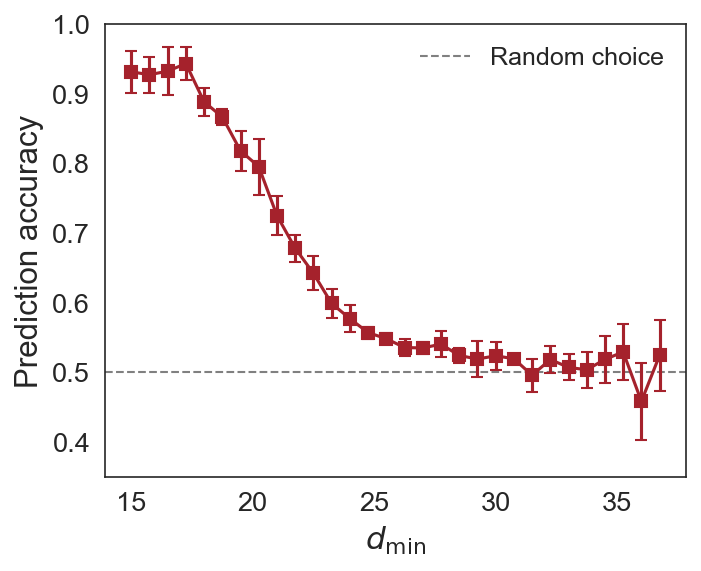

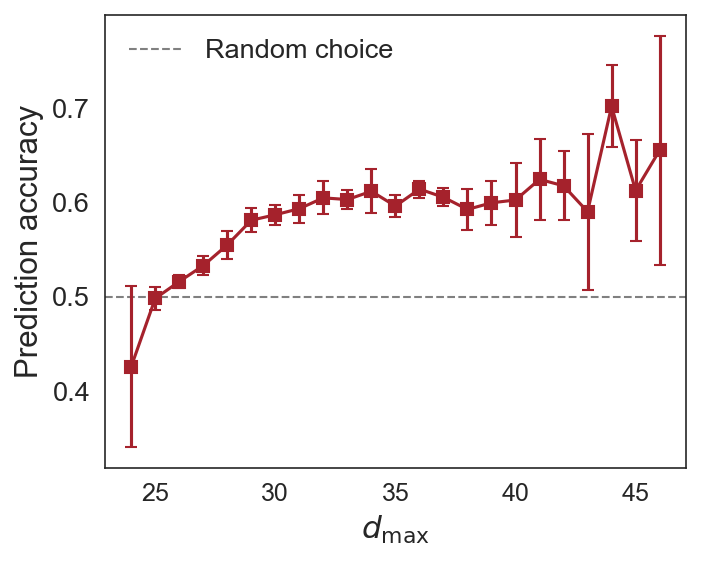

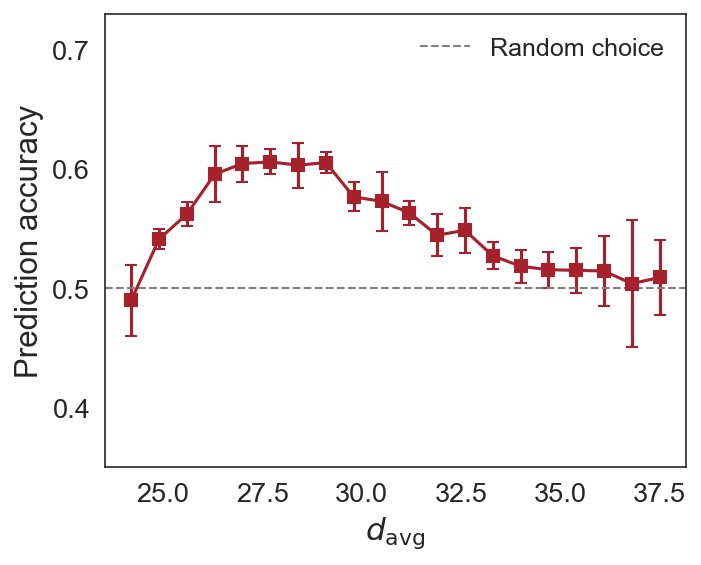

In [25]:
viridis_map = plt.cm.get_cmap('Reds')
color_values = np.linspace(0, 1, 5)
cmap = [viridis_map(color_val) for color_val in color_values]
mycolor = '#A5222C'


colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

#Min Distance 기준 
plt.figure(figsize=(5,4))
f1_mat= []
acc_mat= []
window = .75
xs = np.arange(15,40,window)

for data_idx in range(5):
    df_ = df_samples[data_idx]
    x_list = []
    f1_list = []
    acc_list = []
    thres = 10
    
    for x1 in xs:
        df_temp = df_[(df_['d_min']>=x1) & (df_['d_min']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)
        f1_list.append( f1_score(df_temp.true_outcome, df_temp.predicted_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))
    
    f1_mat.append(np.array(f1_list))
    acc_mat.append(np.array(acc_list))
    
f1_mat = np.array(f1_mat)
acc_mat = np.array(acc_mat)

err = np.std(f1_mat, axis=0)
acc_err = np.std(acc_mat, axis=0)

plt.axhline(.5,  ls='--', lw=1, color='gray', label='Random choice')        
#plt.errorbar(xs, f1_mat.mean(axis=0), yerr=err, ms=6, elinewidth=1.5, capsize=3, 
#             color=mycolor, fmt="-s", ecolor = mycolor)
plt.errorbar(xs, acc_mat.mean(axis=0), yerr=acc_err, ms=6, elinewidth=1.5, capsize=3, 
             color=mycolor, fmt="-s", ecolor = mycolor)


plt.xlabel(r"$d_{\mathrm{min}}$", fontsize=15)
#plt.ylabel('Average F1-score', fontsize=15)
plt.ylabel('Prediction accuracy', fontsize=15)
plt.xticks(np.arange(15,36,5), fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0.35, 1.0)
plt.legend(frameon=False, fontsize=12)
plt.savefig('../fig/downstream_results/distance_vs_accuracy_(dmin).pdf',transparent=True, bbox_inches='tight')

##########################################################################################
#Max Distance 기준 
plt.figure(figsize=(5,4))
window = 1
xs = np.arange(20, 50, window)
f1_mat= []
acc_mat = [] 

for data_idx in range(5):
    df_ = df_samples[data_idx]
    x_list = []
    f1_list = []
    acc_list = []
    thres = 10

    for x1 in xs:
        df_temp = df_[(df_['d_max']>=x1) & (df_['d_max']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)
        f1_list.append( f1_score(df_temp.true_outcome, df_temp.predicted_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))
    
    f1_mat.append(np.array(f1_list))
    acc_mat.append(np.array(acc_list))
    #plt.plot(x_list, f1_list,  '-', lw=1, color='gray', alpha=0.2)#, label='Data %d'%(data_idx+1))

f1_mat = np.array(f1_mat)
acc_mat = np.array(acc_mat)
err = np.std(f1_mat, axis=0)
acc_err = np.std(acc_mat, axis=0)
plt.axhline(.5,  ls='--', lw=1, color='gray', label='Random choice')        
#plt.errorbar(xs, f1_mat.mean(axis=0), yerr=err, ms=6, elinewidth=1.5, capsize=3, 
#             color=mycolor, fmt="-s", ecolor = mycolor)
plt.errorbar(xs, acc_mat.mean(axis=0), yerr=acc_err, ms=6, elinewidth=1.5, capsize=3, 
             color=mycolor, fmt="-s", ecolor = mycolor)


plt.xlabel(r"$d_{\mathrm{max}}$", fontsize=15)
#plt.ylabel('Average F1-score', fontsize=15)
plt.ylabel('Prediction accuracy', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=13)
plt.legend(frameon=False, fontsize=13, loc=2)
plt.savefig('../fig/downstream_results/distance_vs_accuracy_(dmax).pdf',transparent=True, bbox_inches='tight')

##########################################################################################
#Avg Distance 기준 
plt.figure(figsize=(5,4))
window = .7
xs = np.arange(20, 40, window)
f1_mat= []
acc_mat = []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    x_list = []
    f1_list = []
    acc_list = []
    thres = 10

    for x1 in xs:
        df_temp = df_[(df_['d_avg']>=x1) & (df_['d_avg']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)
        f1_list.append( f1_score(df_temp.true_outcome, df_temp.predicted_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))

    f1_mat.append(np.array(f1_list))
    acc_mat.append(np.array(acc_list))
    #plt.plot(x_list, f1_list,  '-', lw=1, color='gray', alpha=0.2)#, label='Data %d'%(data_idx+1))

f1_mat = np.array(f1_mat)
acc_mat = np.array(acc_mat)
err = np.std(f1_mat, axis=0)
acc_err = np.std(acc_mat, axis=0)
#plt.errorbar(xs, f1_mat.mean(axis=0), yerr=err, ms=6, elinewidth=1.5, capsize=3, 
#             color=mycolor, fmt="-s", ecolor = mycolor)

plt.errorbar(xs, acc_mat.mean(axis=0), yerr=acc_err, ms=6, elinewidth=1.5, capsize=3, 
             color=mycolor, fmt="-s", ecolor = mycolor)

plt.axhline(.5,  ls='--', lw=1, color='gray', label='Random choice')        

plt.ylim(0.35, 0.73)
plt.xlabel(r"$d_{\mathrm{avg}}$", fontsize=15)
#plt.ylabel('Average F1-score', fontsize=15)
plt.ylabel('Prediction accuracy', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks([0.4,0.5,0.6,0.7], fontsize=13)
plt.legend(frameon=False, fontsize=12)
plt.savefig('../fig/downstream_results/distance_vs_accuracy_(dmavg).pdf',transparent=True, bbox_inches='tight')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


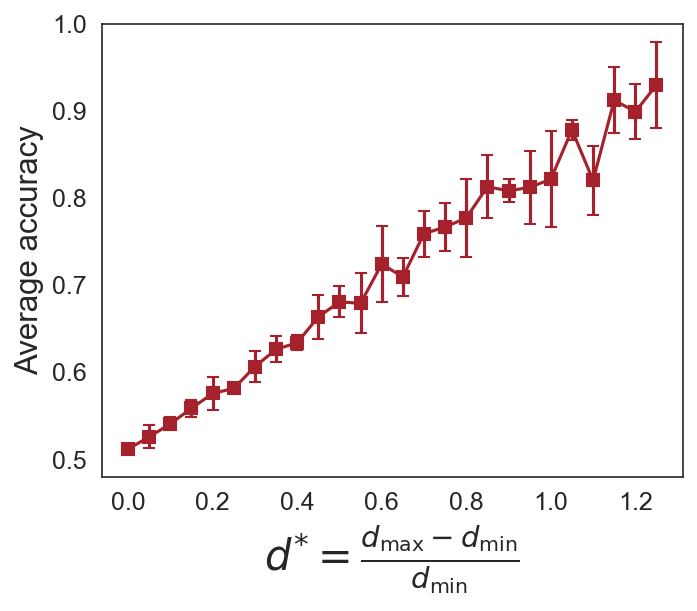

In [26]:
##########################################################################################
#새로운 거리 함수 Distance Function 1

plt.figure(figsize=(5,4))
window = .05
xs = np.arange(0, 1.3, window)
acc_mat= []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    x_list = []
    acc_list = []
    thres = 10

    for x1 in xs:
        df_temp = df_[(df_['d_rel']>=x1) & (df_['d_rel']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)        
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))
    
    acc_mat.append(np.array(acc_list))

acc_mat = np.array(acc_mat)
err = np.std(acc_mat, axis=0)
plt.errorbar(xs, acc_mat.mean(axis=0), yerr=err, ms=6, elinewidth=1.5, capsize=3, 
             color=mycolor, fmt="-s", ecolor = mycolor)

plt.ylim(0.48, 1.0)
plt.xlabel(r'$d^{*}=\frac{d_{\mathrm{max}}-d_{\mathrm{min}}}{d_{\mathrm{min}}}$', fontsize=20)
plt.ylabel('Average accuracy', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False, fontsize=10)
plt.savefig('../fig/downstream_results/distance_vs_accuracy_(d_rel).pdf',transparent=True, bbox_inches='tight')
plt.show()

### Heatmap - Joint distribution

Phase diagram
 - dmin : (15, 35)
 - dmax : (20, 45) 영역으로 제한하여 1씩 bin을 주어 히트맵 생성 
 

In [27]:
x1 = 13 #dmin 
x2 = 40
y1 = 23 #dmax
y2 = 46
xwindow = .6
ywindow = .6

df_ = df_samples[0]
print(len(df_))
df_ = df_[ (df_['d_min'] > x1) & (df_['d_min'] < x2) ]
df_ = df_[ (df_['d_max'] > y1) & (df_['d_max'] < y2) ]
print(len(df_))

df_['xbin'] = ((df_['d_min'] - x1)/xwindow).astype(int)
df_['ybin'] = ((df_['d_max'] - y1)/ywindow).astype(int)

df_.head(1)

33208
33098


,debate_key,debate_title,username,debate_date,position,is_belief,belief_statement,votelen,predicted_outcome,true_outcome,d_min,d_max,d_avg,d_rel,majority_pred,random_pred,Category,xbin,ybin
1,.-Audis-are-junkers-except-to-rich-kids-with-l...,". Audis are junkers, except to rich kids with ...",Max.Wallace,2014-09-04,Pro,1.0,I agree with the following: . Audis are junker...,141,True,True,20.327677,36.096668,28.212173,0.77574,True,0,Cars,12,21


In [28]:
df_['correct_euc'] = df_['predicted_outcome']==df_['true_outcome']

In [29]:
L_x = int(np.ceil((x2-x1)/xwindow)) #dmin
L_y = int(np.ceil((y2-y1)/ywindow)) #dmax

true_map = np.zeros((L_y, L_x))
cnt_map = np.zeros((L_y, L_x))

for i in range(len(df_)):
    cnt_map[df_.iloc[i].ybin][df_.iloc[i].xbin] += 1
    
    if df_.iloc[i].correct_euc == True:
        true_map[df_.iloc[i].ybin][df_.iloc[i].xbin] += 1
    
print(true_map.shape)

(39, 45)


In [30]:
acc_map = true_map / cnt_map

for i in range(L_y):
    for j in range(L_x):
        if cnt_map[i][j] <= 5:
            acc_map[i][j] = 0

is_zero = acc_map == 0
acc_map[is_zero] = np.nan            

/var/folders/r8/jdw1p2tj6jn34wf676kcsw_r0000gn/T/ipykernel_4008/3910540346.py:1: RuntimeWarning: invalid value encountered in divide
  acc_map = true_map / cnt_map


In [31]:
xticks = np.arange(x1, x2, xwindow)
yticks = np.arange(y1, y2, ywindow)
xticks

array([13. , 13.6, 14.2, 14.8, 15.4, 16. , 16.6, 17.2, 17.8, 18.4, 19. ,
       19.6, 20.2, 20.8, 21.4, 22. , 22.6, 23.2, 23.8, 24.4, 25. , 25.6,
       26.2, 26.8, 27.4, 28. , 28.6, 29.2, 29.8, 30.4, 31. , 31.6, 32.2,
       32.8, 33.4, 34. , 34.6, 35.2, 35.8, 36.4, 37. , 37.6, 38.2, 38.8,
       39.4])

In [32]:
x_bins = []
x_vals = []

y_bins = []
y_vals = []

for e in np.arange(0, L_x, 5):
    x_bins.append(e)
    x_vals.append(int(x1+e*xwindow))
    
for e in np.arange(0, L_y, 5):
    y_bins.append(e)
    y_vals.append(int(y1+e*ywindow))    

print(x_bins)
print(x_vals)

[0, 5, 10, 15, 20, 25, 30, 35, 40]
[13, 16, 19, 22, 25, 28, 31, 34, 37]


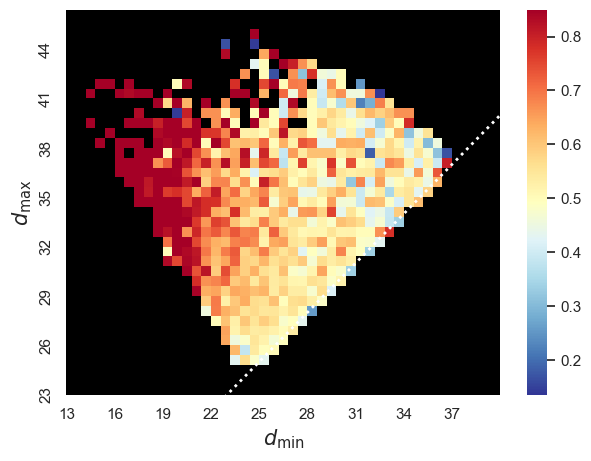

In [33]:
sns.reset_defaults()

fig = plt.figure(figsize=(7,5))
sns.set(rc={'axes.facecolor':'black', "grid.color": ".2", "grid.linestyle": ":"})
ax = sns.heatmap(acc_map, vmin=0.85, vmax=.15, cmap='RdYlBu_r')

t = np.arange(10,60)
ax.plot(t, t*(xwindow/ywindow)-(y1-x1)/ywindow, lw=2, color='w', ls=':')
ax.plot(t, -(xwindow/ywindow)*t + (25-x1-y1)/ywindow, lw=2, color='y', ls='--')
ax.grid(False)
ax.invert_yaxis()
plt.xlabel(r'$d_{\mathrm{min}}$', fontsize=15)
plt.ylabel(r'$d_{\mathrm{max}}$', fontsize=15)
plt.xticks(x_bins, x_vals) #matrix를 heatmap으로 표현해서 x, y 바뀜주의 
plt.yticks(y_bins, y_vals)
#plt.title('Average accuracy')
plt.savefig('../fig/downstream_results/dmin_dmax_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()

## d* vs Accuracy (F1 score) - Political party and Religion dependency

In [34]:
with open('../dataset/User_survey/issue2groups(useridx).p', 'rb') as f:
    category2groups = pickle.load(f)
    
with open('../dataset/User_survey/idx2user.p', 'rb') as f:
    idx2user = pickle.load(f)    
    

 * Adding political party, religion information to each dataframe  

In [35]:
user2party = {}
user2religion = {}

for party in category2groups['Political party']:
    for user_idx in category2groups['Political party'][party]:
        user2party[idx2user[user_idx]] = party

for t in category2groups['Religion']:
    for user_idx in category2groups['Religion'][t]:
        user2religion[idx2user[user_idx]] = t

In [36]:
for i in range(5):
    df_samples[i]['Party'] = df_samples[i]['username'].map(user2party)
    df_samples[i]['Religion'] = df_samples[i]['username'].map(user2religion)

In [37]:
for i in range(5):
    df_samples[i].to_pickle('../dataset/05_Traindata_with_Userinfo/df_train_finetunedSBERT_with_userinfo_idx%d.p'%(i))

### Political party

In [38]:
rep = []
dem = []
for data_idx in range(5):
    df_ = df_samples[data_idx] #dem:1, rep:2
    df_rep = df_[df_['Party']=='Republican']
    df_dem = df_[df_['Party']=='Democratic']
    
    print(len(df_rep.username.unique()), len(df_dem.username.unique()))
    rep.append(len(df_rep.username.unique()))
    dem.append(len(df_dem.username.unique()))
    
print("#dem:%d\n#rep:%d"%(np.mean(dem), np.mean(rep)))

734 682
756 693
711 685
704 670
723 673
#dem:680
#rep:725


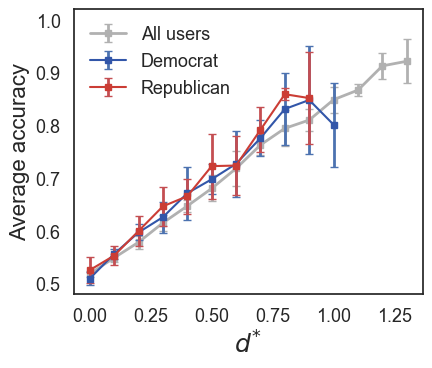

In [39]:
sns.set_style('white')
##########################################################################################
#새로운 거리 함수 Distance Function 1

plt.figure(figsize=(4.5,3.7))

window = .1
xs = np.arange(0, 1.4, window)

#all
f1_mat = []
acc_mat = []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    x_list = []
    f1_list = []
    acc_list = []
    thres = 5

    for x1 in xs:
        df_temp = df_[(df_['d_rel']>=x1) & (df_['d_rel']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)        
        f1_list.append( f1_score(df_temp.predicted_outcome, df_temp.true_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.predicted_outcome == df_temp.true_outcome))
    
    f1_mat.append(np.array(f1_list))
    acc_mat.append(np.array(acc_list))
    #plt.plot(x_list, f1_list,  '-', lw=1, color='gray', alpha=0.2)#, label='Data %d'%(data_idx+1))

#Average
f1_mat = np.array(f1_mat)
acc_mat = np.array(acc_mat)
err = np.std(f1_mat, axis=0)
err_acc = np.std(acc_mat, axis=0)
#plt.errorbar(xs, f1_mat.mean(axis=0), yerr=err, ms=6, lw=3, elinewidth=2, capsize=3,
#             color='#B1B1B1', fmt="o-", ecolor = "#B1B1B1", zorder=0, label='All users')
plt.errorbar(xs, acc_mat.mean(axis=0), yerr=err_acc, ms=5, lw=2, elinewidth=2, capsize=3,
             color='#B1B1B1', fmt="s-", ecolor = "#B1B1B1", zorder=0, label='All users')




#Democratic
f1_mat_dem= []
acc_mat_dem= []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    df_ = df_[df_['Party']=='Democratic']
    x_list = []
    f1_list = []
    acc_list = []
    thres = 5

    for x1 in xs:
        df_temp = df_[(df_['d_rel']>=x1) & (df_['d_rel']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)        
        f1_list.append( f1_score(df_temp.true_outcome, df_temp.predicted_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))
    
    f1_mat_dem.append(np.array(f1_list))
    acc_mat_dem.append(np.array(acc_list))


f1_mat_dem = np.array(f1_mat_dem)
err_dem = np.std(f1_mat_dem, axis=0)
acc_mat_dem = np.array(acc_mat_dem)
err_acc_dem = np.std(acc_mat_dem, axis=0)

#plt.errorbar(xs, f1_mat_dem.mean(axis=0), yerr=err_dem, ms=7, 
#             elinewidth=2, capsize=3, color='b', fmt="-s", ecolor = "b", label='Democrat')

plt.errorbar(xs, acc_mat_dem.mean(axis=0), yerr=err_acc_dem, ms=5, 
             elinewidth=2, capsize=3, color='#3256A9', fmt="-s", ecolor = "b", label='Democrat')


#Republican
f1_mat_rep= []
acc_mat_rep= []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    df_ = df_[df_['Party']=='Republican']
    x_list = []
    f1_list = []
    acc_list = []
    thres = 5

    for x1 in xs:
        df_temp = df_[(df_['d_rel']>=x1) & (df_['d_rel']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)        
        f1_list.append( f1_score(df_temp.true_outcome, df_temp.predicted_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))
    
    f1_mat_rep.append(np.array(f1_list))
    acc_mat_rep.append(np.array(acc_list))


f1_mat_rep = np.array(f1_mat_rep)
err_rep = np.std(f1_mat_rep, axis=0)
#plt.errorbar(xs, f1_mat_rep.mean(axis=0), yerr=err_rep, ms=7, elinewidth=2, 
#             capsize=3, color='r', fmt="-s", ecolor = "r", label='Republican')

acc_mat_rep = np.array(acc_mat_rep)
err_acc_rep = np.std(acc_mat_rep, axis=0)
plt.errorbar(xs, acc_mat_rep.mean(axis=0), yerr=err_acc_rep, ms=5, elinewidth=2, 
             capsize=3, color='#CB3D35', fmt="-s", ecolor = "r", label='Republican')




plt.ylim(0.48, 1.02)
plt.xlabel(r'$d^{*}$', fontsize=18)
plt.ylabel('Average accuracy', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(frameon=False, fontsize=13)
plt.savefig('../fig/downstream_results/drel_vs_Acc_politicalparty.pdf',transparent=True, bbox_inches='tight')
plt.show()

In [40]:
from scipy import stats
#F1-score of Rep, Dem is not significant under t-test for the means of two independent samples
for i in range(len(acc_mat_dem[1,])):
    print(stats.ttest_ind(acc_mat_dem[:,i],  acc_mat_rep[:,i]))

Ttest_indResult(statistic=-1.1901643201396355, pvalue=0.26809938703270797)
Ttest_indResult(statistic=0.2954925880445714, pvalue=0.7751418371907215)
Ttest_indResult(statistic=-0.1659910655312036, pvalue=0.8722823072873769)
Ttest_indResult(statistic=-0.8692880778074612, pvalue=0.41001092895776514)
Ttest_indResult(statistic=0.1886531249003332, pvalue=0.8550625799661502)
Ttest_indResult(statistic=-0.7339489224551627, pvalue=0.4839323538523683)
Ttest_indResult(statistic=0.07682625178504171, pvalue=0.9406484030256259)
Ttest_indResult(statistic=-0.5739819160446671, pvalue=0.5817541840699674)
Ttest_indResult(statistic=-0.8153955660694889, pvalue=0.4384458721275607)
Ttest_indResult(statistic=-0.05377541813795516, pvalue=0.958432733942967)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)


### Religion

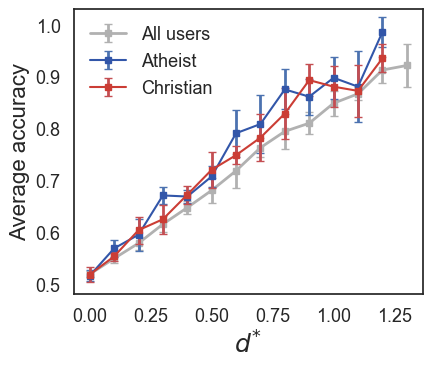

In [41]:
sns.set_style('white')
##########################################################################################
#새로운 거리 함수 Distance Function 1

plt.figure(figsize=(4.5,3.7))

window = .1
xs = np.arange(0, 1.4, window)

#all
f1_mat = []
acc_mat = []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    x_list = []
    f1_list = []
    acc_list = []
    thres = 5

    for x1 in xs:
        df_temp = df_[(df_['d_rel']>=x1) & (df_['d_rel']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)        
        f1_list.append( f1_score(df_temp.predicted_outcome, df_temp.true_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.predicted_outcome == df_temp.true_outcome))
    
    f1_mat.append(np.array(f1_list))
    acc_mat.append(np.array(acc_list))
    #plt.plot(x_list, f1_list,  '-', lw=1, color='gray', alpha=0.2)#, label='Data %d'%(data_idx+1))

#Average
f1_mat = np.array(f1_mat)
acc_mat = np.array(acc_mat)
err = np.std(f1_mat, axis=0)
err_acc = np.std(acc_mat, axis=0)
#plt.errorbar(xs, f1_mat.mean(axis=0), yerr=err, ms=6, lw=3, elinewidth=2, capsize=3,
#             color='#B1B1B1', fmt="o-", ecolor = "#B1B1B1", zorder=0, label='All users')
plt.errorbar(xs, acc_mat.mean(axis=0), yerr=err_acc, ms=5, lw=2, elinewidth=2, capsize=3,
             color='#B1B1B1', fmt="s-", ecolor = "#B1B1B1", zorder=0, label='All users')




#Democratic
f1_mat_dem= []
acc_mat_dem= []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    df_ = df_[df_['Religion']=='Atheist']
    x_list = []
    f1_list = []
    acc_list = []
    thres = 5

    for x1 in xs:
        df_temp = df_[(df_['d_rel']>=x1) & (df_['d_rel']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)        
        f1_list.append( f1_score(df_temp.true_outcome, df_temp.predicted_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))
    
    f1_mat_dem.append(np.array(f1_list))
    acc_mat_dem.append(np.array(acc_list))


f1_mat_dem = np.array(f1_mat_dem)
err_dem = np.std(f1_mat_dem, axis=0)
acc_mat_dem = np.array(acc_mat_dem)
err_acc_dem = np.std(acc_mat_dem, axis=0)

#plt.errorbar(xs, f1_mat_dem.mean(axis=0), yerr=err_dem, ms=7, 
#             elinewidth=2, capsize=3, color='b', fmt="-s", ecolor = "b", label='Democrat')

plt.errorbar(xs, acc_mat_dem.mean(axis=0), yerr=err_acc_dem, ms=5, 
             elinewidth=2, capsize=3, color='#3256A9', fmt="-s", ecolor = "b", label='Atheist')


#Republican
f1_mat_rep= []
acc_mat_rep= []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    df_ = df_[df_['Religion']=='Christian']
    x_list = []
    f1_list = []
    acc_list = []
    thres = 5

    for x1 in xs:
        df_temp = df_[(df_['d_rel']>=x1) & (df_['d_rel']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)        
        f1_list.append( f1_score(df_temp.true_outcome, df_temp.predicted_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))
    
    f1_mat_rep.append(np.array(f1_list))
    acc_mat_rep.append(np.array(acc_list))


f1_mat_rep = np.array(f1_mat_rep)
err_rep = np.std(f1_mat_rep, axis=0) 
#plt.errorbar(xs, f1_mat_rep.mean(axis=0), yerr=err_rep, ms=7, elinewidth=2, 
#             capsize=3, color='r', fmt="-s", ecolor = "r", label='Republican')

acc_mat_rep = np.array(acc_mat_rep)
err_acc_rep = np.std(acc_mat_rep, axis=0)
plt.errorbar(xs, acc_mat_rep.mean(axis=0), yerr=err_acc_rep, ms=5, elinewidth=2, 
             capsize=3, color='#CB3D35', fmt="-s", ecolor = "r", label='Christian')




plt.ylim(0.48, 1.03)
plt.xlabel(r'$d^{*}$', fontsize=18)
plt.ylabel('Average accuracy', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(frameon=False, fontsize=13)
plt.savefig('../fig/downstream_results/drel_vs_Acc_Religion.pdf',transparent=True, bbox_inches='tight')
plt.show()

In [42]:
#F1-score of Rep, Dem is not significant under t-test for the means of two independent samples
for i in range(len(acc_mat_dem[1,])):
    print(stats.ttest_ind(acc_mat_dem[:,i],  acc_mat_rep[:,i]))

Ttest_indResult(statistic=-0.256941561845219, pvalue=0.8037086707972781)
Ttest_indResult(statistic=1.5902444241022902, pvalue=0.15044362426200128)
Ttest_indResult(statistic=-0.43369104445592427, pvalue=0.6759703930212121)
Ttest_indResult(statistic=2.7806139775098306, pvalue=0.023901906019110554)
Ttest_indResult(statistic=-0.3160653481867275, pvalue=0.7600417560611522)
Ttest_indResult(statistic=-0.642142925204151, pvalue=0.5387417801452486)
Ttest_indResult(statistic=1.7496148743548885, pvalue=0.11830207793719617)
Ttest_indResult(statistic=0.7295021502789373, pvalue=0.48650180415347366)
Ttest_indResult(statistic=1.480475078397147, pvalue=0.1770177295582995)
Ttest_indResult(statistic=-1.3735485503643268, pvalue=0.20683914523432123)
Ttest_indResult(statistic=0.6073890121659954, pvalue=0.5604335004338183)
Ttest_indResult(statistic=0.19205732261355543, pvalue=0.8524827819263898)
Ttest_indResult(statistic=2.577524408542872, pvalue=0.03274212903985953)
Ttest_indResult(statistic=nan, pvalue=nan

## Category vs. d*